## Generative adversarial networks
### Generating of MNIST digits with a GAN

Setting up

In [72]:
!pip3 install tqdm
!pip3 install torchsummary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [73]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchsummary import summary
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

Check that we're running on GPU, and initialize our device

In [154]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    print("The code will run on GPU for MacOS devices with Metal programming framework.")
    device = torch.device('mps')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')

The code will run on GPU for MacOS devices with Metal programming framework.


Setup our MNIST dataloaders

In [155]:
batch_size = 64     # Batch size
nz = 100            # Size of the input noise vector
ngf = 48            # Scale number of conv filters in generator
ndf = 32            # Scale number of conv filters in discriminator
nc = 1              # Number of channels in the output image (RGB or black and white ecc)

In [156]:
# MNIST dataset
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Fashion MNIST dataset
"""
trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
"""

In [144]:
# SIZE TESTS
# ========================
a = nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
b = nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False)
c = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
n = torch.rand(100, 1, 1)
c(b(a(n))).shape

torch.Size([96, 14, 14])

## LSGAN

Implement **generator** network.

In [158]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        self.input_size = input_size

        """
        self.fullyconnected = nn.Sequential(
            nn.Linear(nz, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(num_features=1024),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(num_features=1024),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(num_features=1024),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.Linear(1024, 28 * 28),
            nn.Tanh(),
        )
        """

        # CONVOLUTIONAL MODEL
        self.convolution = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( self.input_size, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. (nc) x 28 x 28
        )
        
    def forward(self, x):
        # FEEDFOREWARD MODEL
        #x = self.fullyconnected(x)
        #x = x.view(x.size(0), 1, 28, 28)

        # CONVOLUTIONAL MODEL
        x = self.convolution(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

Implement **discriminator** network.

In [159]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        """
        self.fulluconnected = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(0.1),
            #nn.BatchNorm1d(num_features=1024)
            nn.Linear(1024, 512),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(0.1),
            #nn.BatchNorm1d(num_features=512),
            nn.Linear(512, 256),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(0.1),
            #nn.BatchNorm1d(num_features=256),
            nn.Linear(256, 1),
            #nn.Sigmoid() #not usefull for LSGAN
        )
        """

        self.convolution = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # state size. (1) x 1 x 1
        )
    
    def forward(self, x):
        # FEEDFOREWARD MODEL
        # x = x.view(x.size(0), -1)
        #x = self.fulluconnected(x)

        # CONVOLUTIONAL MODEL
        x = self.convolution(x)
        x = x.view(x.size(0), 1)        
        return x

Train model.

In [160]:
d = Discriminator().to(device)
#summary(d, (1, 28, 28))
g = Generator(nz).to(device)
#summary(g, (100, 1, 1))

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_filled(size, value):
    data = Variable(torch.full(size, value))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

#def make_noise(batch_size, size):
#    return torch.randn(batch_size, size).to(device)

def make_noise(batch_size, size):
    return torch.randn(batch_size, size, 1, 1).to(device)

KeyboardInterrupt: 

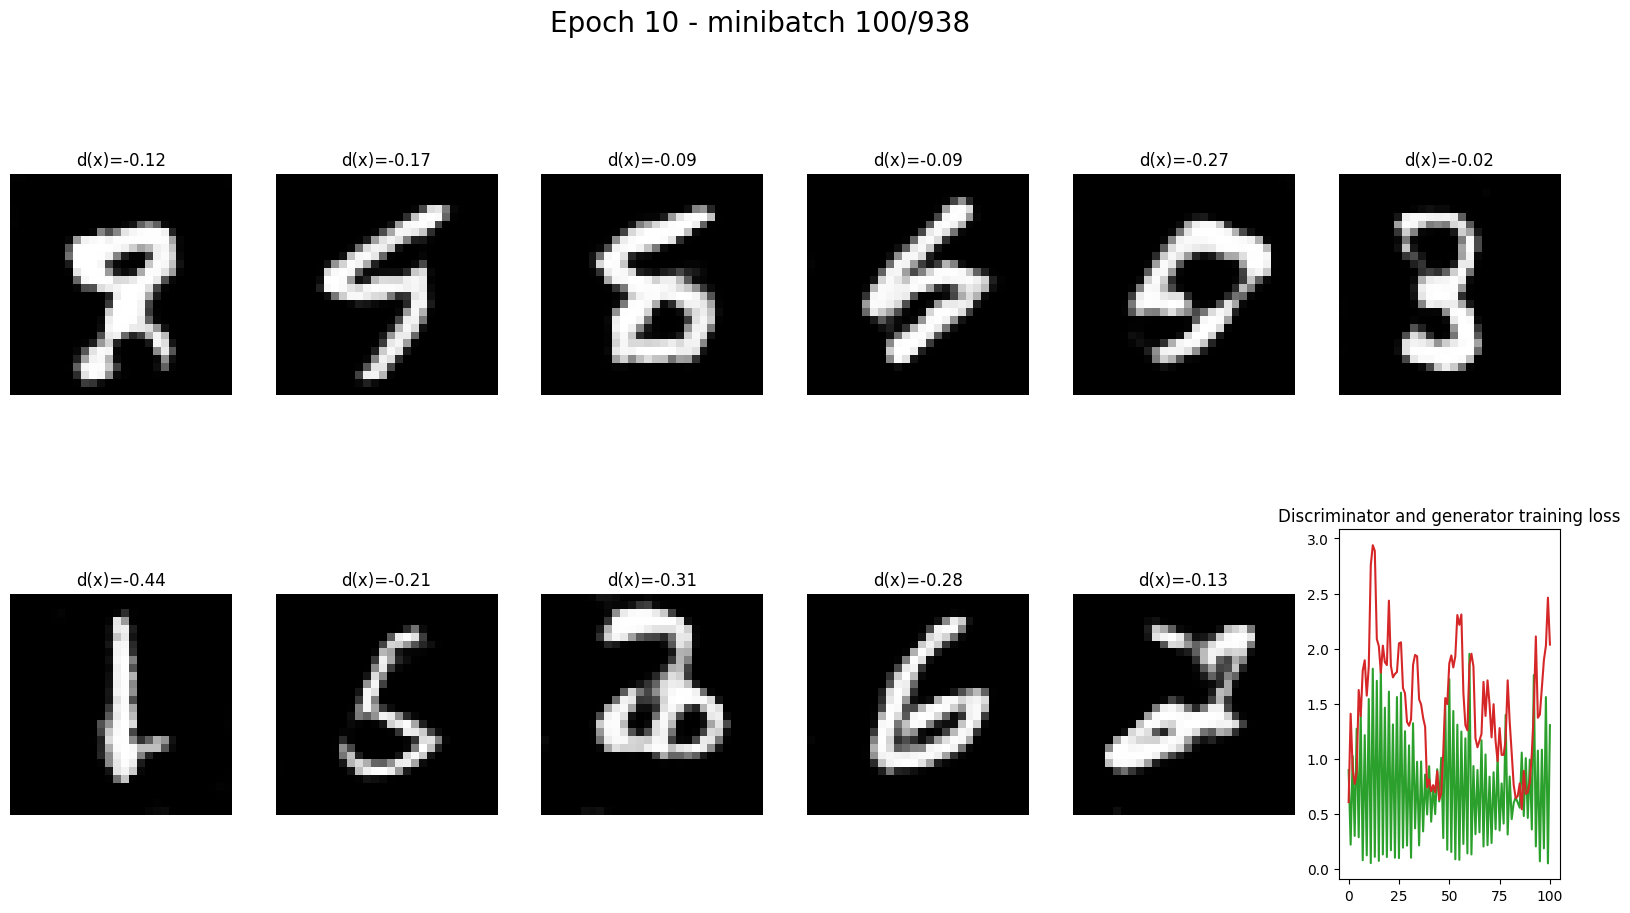

In [161]:
#Initialize networks
d_opt = torch.optim.Adam(d.parameters(), 0.004, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.001, (0.5, 0.999))
#d_opt = torch.optim.Adam(d.parameters(), lr=2e-4)
#g_opt = torch.optim.Adam(g.parameters(), lr=2e-4)

plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10

d.train()
g.train()
d_loss_fun = nn.MSELoss()
for epoch in range(num_epochs):
    g_loss = d_loss = 0.0
    g_losses = []
    d_losses = []
    subplots[-1].clear()
    torch.save(g.state_dict(), "generator.pt")
    torch.save(d.state_dict(), "discriminator.pt")
    for minibatch_no, (x, target) in enumerate(train_loader):

        def train_discriminator(optimizer, x_real, x_fake):
            d.zero_grad() #reset gradients
        
            #train discriminator to recognize real images
            loss = 0.0
            for k in range(5):
                prediction_real = d(x_real)
                n = prediction_real.size(0) #get batch size
                d_loss_real = d_loss_fun(prediction_real, make_ones(n))
                d_loss_real.backward()

                #train discriminator to recognize fake images
                prediction_fake = d(x_fake)
                n = prediction_fake.size(0) #get batch size
                d_loss_fake = d_loss_fun(prediction_fake, make_zeros(n)) #for V.GAN & LSGAN
                #d_loss_fake = d_loss_fun(prediction_fake, make_filled(n, 0.0))
            
                d_loss_fake.backward()
        
                #update weights
                optimizer.step()
                loss += d_loss_real.detach().cpu().numpy() + d_loss_fake.detach().cpu().numpy()
            return loss

        def train_generator(optimizer, x_fake):
            g.zero_grad() #reset gradients
        
            #train generator to fool discriminator
            prediction = d(x_fake)
            n = prediction.size(0) #get batch size
            g_loss = d_loss_fun(prediction, make_ones(n))
            g_loss.backward()
        
            #update weights
            optimizer.step()
            return g_loss.detach().cpu().numpy()
        
        #====================
        # Update discriminator
        #====================
        #make real and fake image
        x_real = x.to(device) * 2 -1 #scale to (-1, 1) range
        x_fake = g(make_noise(batch_size, g.input_size))
        
        #remember to detach x_fake before using it to compute the discriminator loss
        #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
        x_fake = x_fake.detach()
        
        d_losses.append(train_discriminator(d_opt, x_real, x_fake))
        d_loss += d_losses[-1]
        
        #========================
        # Update generator
        #========================
        #feed random noise to generator
        x_fake = g(make_noise(batch_size, g.input_size))
        g_losses.append(train_generator(g_opt, x_fake))
        g_loss += d_losses[-1]
        
        assert(not np.isnan(d_loss))
        #Plot results every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad():
                x_fake = g(make_noise(batch_size, g.input_size)).detach()
                P = d(x_fake)
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(x_fake_k, cmap='gray')
                    subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                z = torch.randn(batch_size, 100, 1, 1).to(device)
                H1 = d(g(z)).cpu()
                H2 = d(x_real).cpu()
                plot_min = min(H1.min(), H2.min()).item()
                plot_max = max(H1.max(), H2.max()).item()
                #subplots[-1].cla()
                subplots[-1].plot(np.arange(len(g_losses)), g_losses)
                subplots[-1].plot(np.arange(len(d_losses)), d_losses)
                #subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator and generator training loss')
                
                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_loss/max(1, minibatch_no), d_loss/max(1, minibatch_no)))
                display.clear_output(wait=True)
                

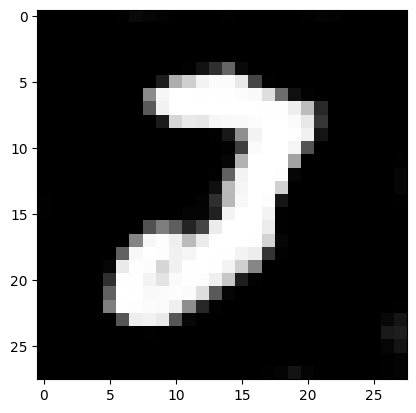

In [168]:
g.load_state_dict(torch.load("generator.pt"))
g.eval()
target_image = g(make_noise(1, g.input_size)).detach()
target_image = target_image[0].cpu().squeeze() / 2 + 0.5
plt.imshow(target_image, cmap='gray')


x_fake = g(make_noise(1, g.input_size)).detach()

In [ ]:
def interpolate_linear_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
    return asarray(vectors)

# spherical linear interpolation (slerp)
def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high
 
# uniform interpolation between two points in latent space
def interpolate_spherical_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = slerp(ratio, p1, p2)
        vectors.append(v)
    return asarray(vectors)

print(interpolate_linear_points([0, 1, 0], [1, 0, 1]))

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

## WGAN
The differences in implementation for the WGAN are as follows:
1. Use a linear activation function in the output layer of the critic model (instead of sigmoid).
2. Use -1 labels for real images and 1 labels for fake images (instead of 1 and 0).
3. Use Wasserstein loss to train the critic and generator models.
4. Constrain critic model weights to a limited range after each mini batch update (e.g. [-0.01,0.01]).
5. Update the critic model more times than the generator each iteration (e.g. 5).
6. Use the RMSProp version of gradient descent with a small learning rate and no momentum (e.g. 0.00005).
